In [2]:
# Comparing RO to INS data

import sys
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts")
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts/config")
sys.path.append("/Users/roberto/code/corelibs/src/tools-python")
sys.path.append("/Users/roberto/code/corelibs/build/datatypes")
sys.path.append("/Users/roberto/code/corelibs/build/datatypes/datatypes_python")
sys.path.append("/Users/roberto/code/radar-utilities/build/radarutilities_datatypes_python")
from figs import plot
import motion

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
from numpy import *
import module
import settings

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 28})
plt.rcParams['text.usetex'] = True
plt.rc("text", usetex=True)
plt.rc("font", family='serif')
module.set_sys_paths()

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

from mrg.logging.monolithic_encoder import encodeForMonolithic
sys.path.append("/Users/roberto/code/radar-utilities/build/radarutilities_datatypes_python/"
                "protobuf/classification_score")
import pbClassificationScore_pb2 as pbClassificationScore_pb2

import numpy as np
from config.data import *

In [3]:
# dataset_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/" \
#                "2018-06-21-16-24-39-long-hanborough-to-ori-V4-radar-leopon-trial-sunny-long-range/"
dataset_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/" \
               "2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/"
# dataset_path="/Users/roberto/data/odometry-comparisons/rugged_ro/2018-07-27-15-35-23-long-hanbourgh-to-ori/"
INS_relative_poses_path = dataset_path+"motion_estimation/ground-truth/flattened_novatel_generated_poses.monolithic"
# RO_relative_poses_path = dataset_path+"motion_estimation/untuned-kalman-with-chi-all-good-labels/radar_motion_estimation.monolithic"
RO_relative_poses_path = dataset_path+"motion_estimation/standard-ro/radar_motion_estimation.monolithic"

# INS_relative_poses_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/ground-truth/flattened_novatel_generated_poses.monolithic"
# RO_relative_poses_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/standard-ro/radar_motion_estimation.monolithic"

# INS_relative_poses_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/2018-07-27-15-35-23-long-hanbourgh-to-ori/motion_estimation/ground-truth/flattened_novatel_generated_poses.monolithic"
# RO_relative_poses_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/2018-07-27-15-35-23-long-hanbourgh-to-ori/motion_estimation/standard-ro/radar_motion_estimation.monolithic"

# INS - open monolithic and iterate frames
print("reading INS_relative_poses_path: " + INS_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    INS_relative_poses_path)

# iterate mono
INS_se3s = []
INS_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    INS_se3s.append(serialised_transform[0])
    INS_timestamps.append(serialised_transform[1])
    
# RO - open monolithic and iterate frames
print("reading RO_relative_poses_path: " + RO_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    RO_relative_poses_path)

# iterate mono
RO_se3s = []
RO_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    RO_se3s.append(serialised_transform[0])
    RO_timestamps.append(serialised_transform[1])

reading INS_relative_poses_path: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/ground-truth/flattened_novatel_generated_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
reading RO_relative_poses_path: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/standard-ro/radar_motion_estimation.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2


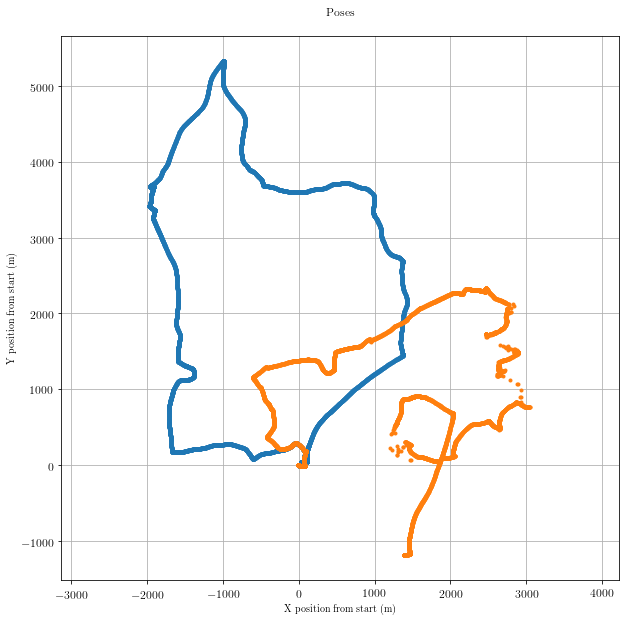

In [4]:
# get INS poses
INS_poses = []
pose = np.identity(4)
for i in range(len(INS_se3s)):
    pose = pose * INS_se3s[i]
    INS_poses.append(pose)

# get x,y coords
x_INS = [pose[0, 3] for pose in INS_poses]
y_INS = [pose[1, 3] for pose in INS_poses]
# downsample INS for figure rendering
x_INS_lite = x_INS[::10]
y_INS_lite = y_INS[::10]

# get RO poses
RO_poses = []
pose = np.identity(4)
for i in range(len(RO_se3s)):
    pose = pose * RO_se3s[i]
    RO_poses.append(pose)

# get x,y coords
x_RO = [pose[0, 3] for pose in RO_poses]
y_RO = [pose[1, 3] for pose in RO_poses]

plt.figure(figsize=(10,10))
plt.plot(x_INS_lite,y_INS_lite,'.');
plt.plot(x_RO,y_RO,'.');
plt.axis('equal');
plt.title('Poses');
plt.xlabel('X position from start (m)');
plt.ylabel('Y position from start (m)');

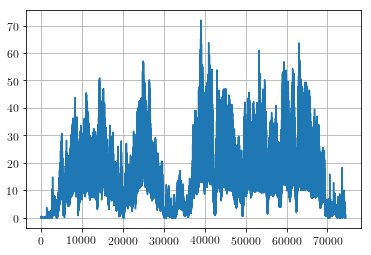

In [5]:
# get INS speeds
assert len(INS_se3s) == len(INS_timestamps)
INS_speeds = []
INS_TIMESTAMPS = []
deltatime_arr = []
for i in range(len(INS_timestamps) - 1):
# for i in range(0,len(timestamps) - 1,10): # this fixed the glitches by skipping them
# for i in range(1000,2000):
    # work out speed
    delta_time = INS_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION \
        - INS_timestamps[i] / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = INS_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    INS_speeds.append(speed)
    INS_TIMESTAMPS.append(INS_timestamps[i])
# plt.ylim(0,1000000)
plt.plot(INS_speeds);

In [6]:
# RO_timestamps[0] = RO_timestamps[1]-250000

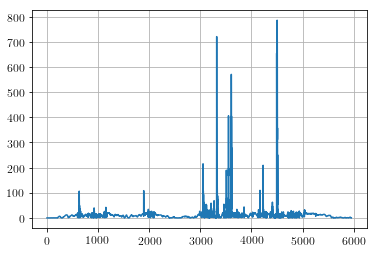

In [7]:
# get speeds
assert len(RO_se3s) == len(RO_timestamps)
RO_speeds = []
RO_TIMESTAMPS = []
deltatime_arr = []
for i in range(len(RO_timestamps) - 1):
# for i in range(0,len(timestamps) - 1,10): # this fixed the glitches by skipping them
# for i in range(1000,2000):
    # work out speed
    delta_time = RO_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION \
        - RO_timestamps[i] / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = RO_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    RO_speeds.append(speed)
    RO_TIMESTAMPS.append(RO_timestamps[i])
plt.plot(RO_speeds);

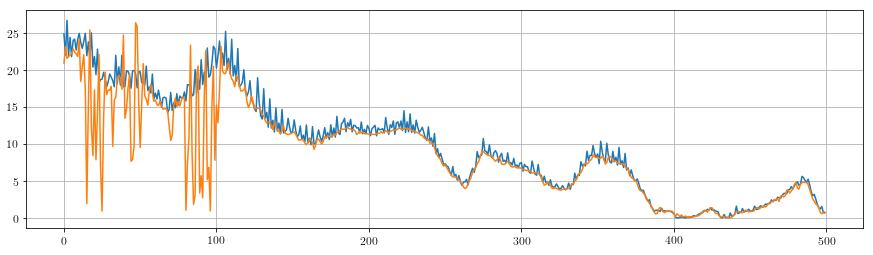

In [8]:
# Do interpolation (accumulatation for now)
interp_INS_speed = []
distance = 0
temp_speed = 0
j = 0
for i in range(len(RO_timestamps)):
    while(INS_timestamps[j] < RO_timestamps[i]):
        distance += INS_speeds[j]*(INS_timestamps[j]-INS_timestamps[j-1])
        j+=1
    temp_speed = distance/(RO_timestamps[i]-RO_timestamps[i-1])
    interp_INS_speed.append(temp_speed)
    distance = 0
plt.figure(figsize=(15,4))
plt.plot(interp_INS_speed[2000:2500])
plt.plot(RO_speeds[2000:2500])

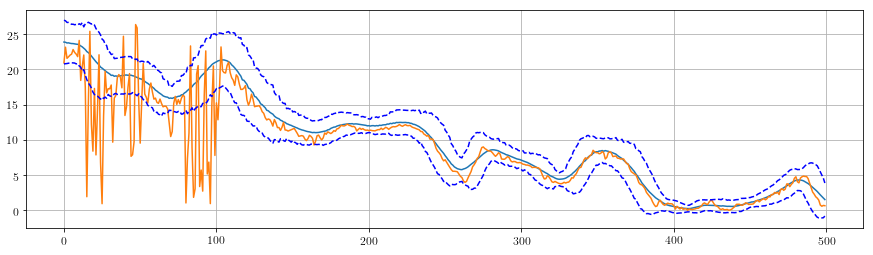

In [9]:
window_size = 20
std_devs = []
means = []
n_sigmas = 2
for i in range(window_size//2,len(interp_INS_speed)-window_size//2):
    window_contents = interp_INS_speed[i-window_size//2:i+window_size//2]
    std_devs.append(std(window_contents))
    means.append(mean(window_contents))
    
means = np.array(means)
means[-window_size//2:] = 0
means = np.roll(means,window_size//2)

std_devs = np.array(std_devs)
std_devs[-window_size//2:] = 0
std_devs = np.roll(std_devs,window_size//2)

plt.figure(figsize=(15,4))
plt.plot(means[2000:2500])
plt.plot(RO_speeds[2000:2500])
plt.plot(means[2000:2500]+n_sigmas*std_devs[2000:2500],'b--')
plt.plot(means[2000:2500]-n_sigmas*std_devs[2000:2500],'b--')
# plt.plot(means[2000:2500])
# plt.plot(RO_speeds[2005:2505])
# plt.plot(means[2000:2500]+n_sigmas*std_devs[2000:2500],'b--')
# plt.plot(means[2000:2500]-n_sigmas*std_devs[2000:2500],'b--')

(-5, 100)

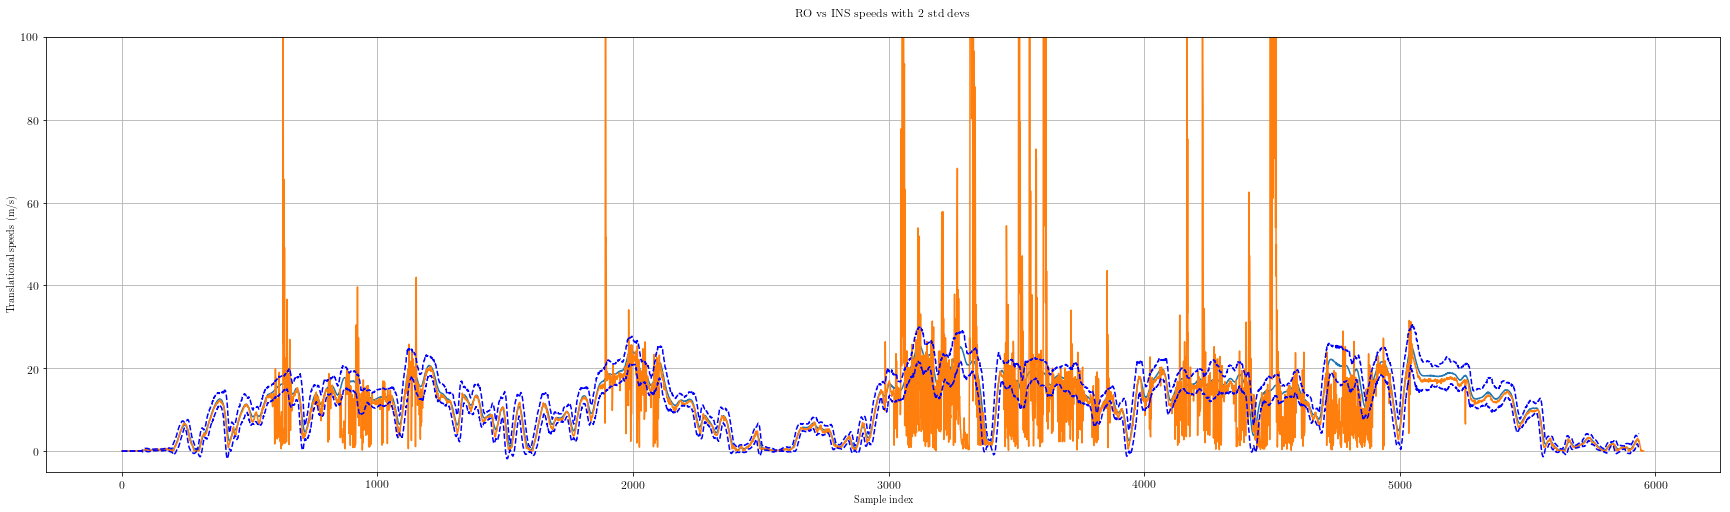

In [10]:
plt.figure(figsize=(30,8))
plt.title('RO vs INS speeds with 2 std devs')
plt.ylabel('Translational speeds (m/s)')
plt.xlabel('Sample index')
plt.plot(means)
plt.plot(RO_speeds)
plt.plot(means+n_sigmas*std_devs,'b--')
plt.plot(means-n_sigmas*std_devs,'b--')
# plt.plot(means+3*std_devs,'k--')
# plt.plot(means-3*std_devs,'k--')
plt.ylim(-5,100)

In [11]:
# Checking for failures based on speeds (not accelerations)
m = len(means)
upper_thresh = means + n_sigmas*std_devs
lower_thresh = means - n_sigmas*std_devs
minimum_speed_to_label = 0.5
label_reach_back = 0 #2
classification = ones(m)*-1
for i in range(m):
    if(RO_speeds[i] < lower_thresh[i]) or RO_speeds[i] > upper_thresh[i]:
        if(means[i] > minimum_speed_to_label):
            classification[i-label_reach_back:i+1] = 1;
#     else:
#         classification[i+window_size//2,] = -1;

Detected failures: 1265 of 5936 samples


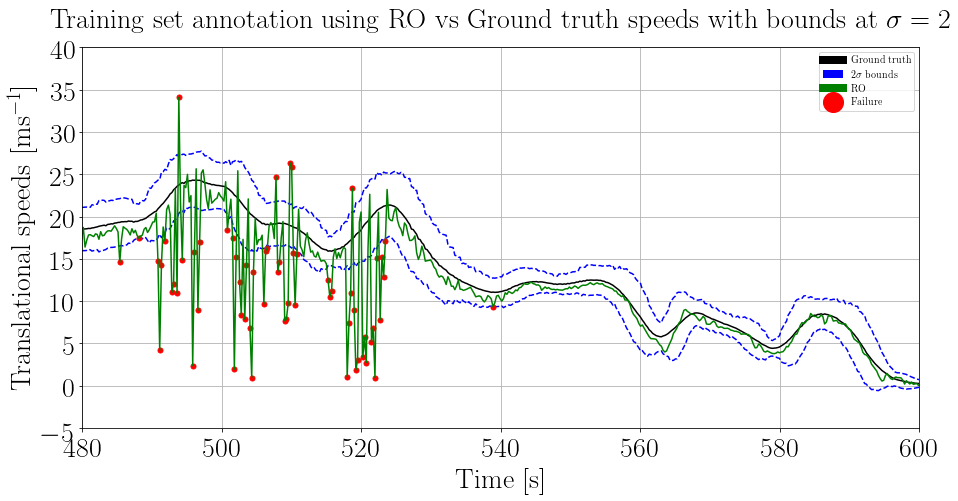

In [12]:
t_ro = np.array([x - RO_TIMESTAMPS[0] for x in RO_TIMESTAMPS])
t_ro = t_ro/1e6
t_ins = t_ro[:-19]

fontsize=28

plt.figure(figsize=(15,7))
ax = plt.subplot(111, xlabel='Time [s]', ylabel='Translational speeds [ms$^{-1}$]',
                 title='Training set annotation using RO vs Ground truth speeds with bounds at $\sigma = 2$')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(28)
    
# plt.title('',fontsize=fontsize)
# plt.ylabel('',fontsize=fontsize)
# plt.xlabel('Time [s]',fontsize=fontsize)
# plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=fontsize)
# plt.setp(ax.get_yticklabels(), rotation='vertical', fontsize=fontsize)

ax.plot(t_ins,means,'k')
ax.plot(t_ins,means+n_sigmas*std_devs,'b--')
ax.plot(t_ins,means-n_sigmas*std_devs,'b--')
for i in range(m):
    if(classification[i] == 1):
        ax.plot(t_ro[i],RO_speeds[i],'r.-',markersize=10)
#     else:
ax.plot(t_ro,RO_speeds,'g-',markersize=0.5) 

line1, = ax.plot([],[],color='black',label='Ground truth',linewidth=8.0)
line2, = ax.plot([],[],'b--',label='2$\sigma$ bounds',linewidth=8.0)
line3, = ax.plot([],[],color='green',label='RO',linewidth=8.0)
line4, = ax.plot([],[],'r.',label='Failure',markersize=40)
ax.legend(handles=[line1,line2,line3,line4])

plt.ylim(-5,40)
x1 = 480
x2 = x1 + 120
plt.xlim([x1,x2])

total_bad_ro = np.count_nonzero(classification==1)
print('Detected failures:',total_bad_ro,"of",m,'samples')
# plt.savefig(dataset_path+"figs/filename_labels_speeds_partial.pdf",bbox_inches='tight',pad_inches = 0)

In [16]:
# from sklearn import datasets

plot_figures = True
dateAndTime = "2019-03-18-15-00-42-velCorrectorOn/";
# dateAndTime = "2019-04-02-08-39-24/"
filename = dataset_path+"motion_estimation/standard-ro/"+dateAndTime;
print('Reading from: ' + filename)
failure_label = 1

# Read from files into dataframes
# df_xyz_yaw = pd.read_csv(filename+'xyz_yaw.csv',names=range(4))
df_MaxEVec = pd.read_csv(filename+'MaxEVec.csv',names=range(2400))

# print("Shape of xyz_yaw is:\n",shape(df_xyz_yaw))
print("Shape of MaxEVec is:\n",shape(df_MaxEVec))
[a,b] = shape(df_MaxEVec)


Reading from: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/standard-ro/2019-03-18-15-00-42-velCorrectorOn/
Shape of MaxEVec is:
 (5955, 2400)


In [14]:
where_are_NaNs = isnan(df_MaxEVec)
df_MaxEVec[where_are_NaNs] = 0.0
df_MaxEVec.head()
EVec_timestamps = df_MaxEVec[[0]]
EVec_timestamps = np.array(EVec_timestamps)
max_evec = np.copy(df_MaxEVec.iloc[:,1:2400].values)

5955
Failures in this window: 1265


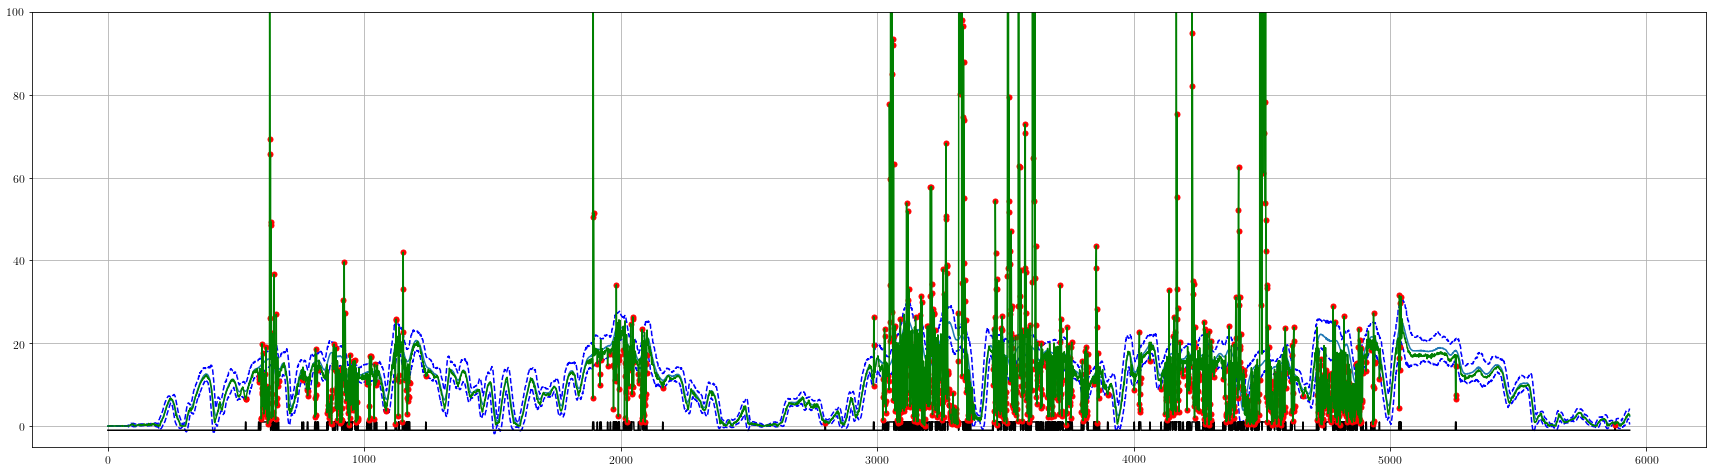

In [15]:
# Get error indices
# Account for offset because of window size

num_evecs = len(max_evec)
labels = ones(num_evecs)*-1 # this assumes first and last few labels are good matches
for i in range(m):
    if(classification[i] == 1):
        labels[i] = 1
    else:
        labels[i] = -1
print(size(labels))
# plt.plot(labels)

plt.figure(figsize=(30,8))
start, finish = 0,m
plt.plot(means[start:finish])
plt.plot(means[start:finish]+n_sigmas*std_devs[start:finish],'b--')
plt.plot(means[start:finish]-n_sigmas*std_devs[start:finish],'b--')
# plt.plot(RO_speeds[start:finish],'g');
plt.plot(labels[start:finish],'k');
for i in range(start,finish):
    if(labels[i] == 1):
        plt.plot(i-start,RO_speeds[i],'r.-',markersize=10)
#     else:
plt.plot(RO_speeds[start:finish],'g-',markersize=0.5)
plt.ylim(-5,100);
print('Failures in this window:',np.count_nonzero(labels[start:finish]==1))

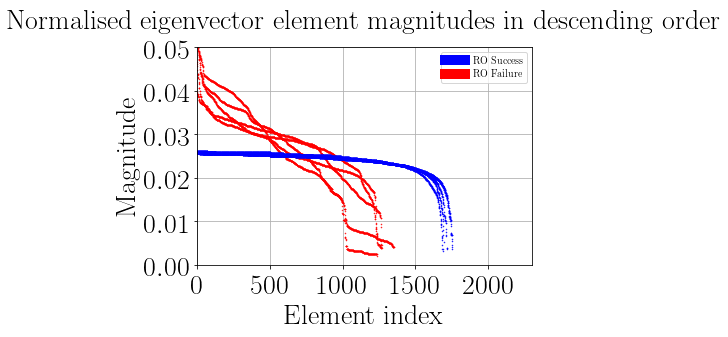

In [18]:
## plt.figure(figsize=(15,7))
ax = plt.subplot(111, xlabel='Element index', ylabel='Magnitude',
                 title='Normalised eigenvector element magnitudes in descending order')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(28)

sorted_max_evecs = max_evec
for i in range(num_evecs): # to sort all of them
    sorted_max_evecs[i] = sort(max_evec[i])[::-1]
#for plotting
sorted_max_evecs_lite = np.array(sorted_max_evecs)
sorted_max_evecs_lite[sorted_max_evecs_lite==0] = np.nan
i1 = 3050
i2 = i1 + 5
for i in range(i1,i2):
    if(labels[i] == failure_label):
        ax.plot(sorted_max_evecs_lite[i,:],'.',markersize=1,color='red');
    else:
        plt.plot(sorted_max_evecs_lite[i,:],'.',markersize=1,color='blue');
i1 = 100
i2 = i1 + 5
for i in range(i1,i2):
    if(labels[i] == failure_label):
        ax.plot(sorted_max_evecs_lite[i,:],'.',markersize=1,color='red');
    else:
        plt.plot(sorted_max_evecs_lite[i,:],'.',markersize=1,color='blue');

ax.set_xlim([0,2300])
ax.set_ylim([0,0.05])
line1, = plt.plot([],[],color='blue',label='RO Success',linewidth=10.0)
line2, = plt.plot([],[],color='red',label='RO Failure',linewidth=10.0)

ax.legend(handles=[line1,line2],loc='best')
fig_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/"\
"2018-06-21-16-24-39-long-hanborough-to-ori-V4-radar-leopon-trial-sunny-long-range/figs/"
plt.savefig(fig_path+"filename_evectors.pdf",bbox_inches='tight',pad_inches = 0)

In [19]:
print(size(labels))
print(len(sorted_max_evecs))
print(m)
print(len(means))

5955
5955
5936
5936


In [20]:
start = 0
finish = num_evecs
combined_data = c_[labels[start:finish], sorted_max_evecs[start:finish]]
# combined_data = c_[labels, sorted_max_evecs[0:m]]
print(combined_data)
print("Saving to directory: ",filename)
savetxt(filename+'tmp_combined_data.csv',combined_data,fmt='%s',delimiter=',');
print(shape(combined_data))
new_labels_temp = labels[start:finish] + ones(finish-start)
print(np.count_nonzero(new_labels_temp),"instances of RO labelled failure.")

[[-1.         0.0267034  0.0267006 ...  0.         0.         0.       ]
 [-1.         0.0269097  0.0269023 ...  0.         0.         0.       ]
 [-1.         0.0269179  0.0269161 ...  0.         0.         0.       ]
 ...
 [-1.         0.0267781  0.0267752 ...  0.         0.         0.       ]
 [-1.         0.0266735  0.0266676 ...  0.         0.         0.       ]
 [-1.         0.026553   0.0265527 ...  0.         0.         0.       ]]
Saving to directory:  /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/standard-ro/2019-03-18-15-00-42-velCorrectorOn/
(5955, 2400)
1265 instances of RO labelled failure.


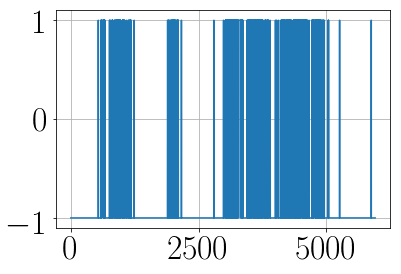

In [37]:
len(RO_timestamps)
plt.plot(labels)

In [40]:
# Write labels to monolithic
write_mono_labels = True
if(write_mono_labels == True):
#     labels_filename = "/Users/roberto/data/odometry-comparisons/rugged_ro/"\
#     "2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/"\
#     "ground-truth/tempy-labels.monolithic"
    labels_filename = "/Users/roberto/data/odometry-comparisons/rugged_ro/training_gt_labels_KFC.monolithic"
    print("writing to labels monolithic: " + labels_filename + "...")
    with open(labels_filename, 'wb') as file_handle:
        for i in range(start,finish):
            pb_classification_score = pbClassificationScore_pb2.pbClassificationScore()
            pb_classification_score.timestamp = RO_timestamps[i]
            if(labels[i] == -1):
                # Good match
                pb_classification_score.score = 0 
            else:
                # Bad match
                pb_classification_score.score = 1
            file_handle.write(
                encodeForMonolithic(
                    pb_classification_score,
                    'radarutilities.datatypes.protobuf.classification_score.pbClassificationScore') +
                b"\n")
    print("Finished.")
    print("Size of labels in monolithic is:",len(labels))

writing to labels monolithic: /Users/roberto/data/odometry-comparisons/rugged_ro/training_gt_labels_KFC.monolithic...
Finished.
Size of labels in monolithic is: 5955
